In [15]:
import pandas as pd
import os
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor
import xgboost as xgb
from sklearn.model_selection import cross_val_score

# Load the CSV file
file_path = os.path.join("..", "Final Data", "FINAL-THESIS-DATA.csv")
df = pd.read_csv(file_path)


In [16]:
# Add lag features for climate and dengue cases
for i in range(1, 3):
    df[f'Lag_{i}_Months_Temperature'] = df.groupby('Barangay')['Temperature'].shift(i).fillna(0)
    df[f'Lag_{i}_Months_Rainfall'] = df.groupby('Barangay')['Rainfall'].shift(i).fillna(0)
    df[f'Lag_{i}_Months_Humidity'] = df.groupby('Barangay')['Humidity'].shift(i).fillna(0)
    df[f'Lag_{i}_Months_Cases'] = df.groupby('Barangay')['Dengue Cases'].shift(i).fillna(0)
    
# Rolling Mean (Trend Features)
df["Cases_Rolling_Mean"] = df.groupby("Barangay")["Dengue Cases"].rolling(3).mean().reset_index(level=0, drop=True)

# Cyclical Encoding for Month
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

In [17]:
# Define Features and Target
features = [
    'Temperature', 'Rainfall', 'Humidity', 'x', 'y', 'Year',  'Cases_Rolling_Mean',
    'Month_sin', 'Month_cos'
] + [f'Lag_{i}_Months_Temperature' for i in range(1, 3)] \
  + [f'Lag_{i}_Months_Rainfall' for i in range(1, 3)] \
  + [f'Lag_{i}_Months_Humidity' for i in range(1, 3)] \
  + [f'Lag_{i}_Months_Cases' for i in range(1, 3)]

target = 'Dengue Cases'

# Drop rows with NaN from lag and rolling
df = df.dropna()

In [18]:
from sklearn.model_selection import TimeSeriesSplit

# Set up TimeSeriesSplit with 3 splits
tscv = TimeSeriesSplit(n_splits=3)

for fold, (train_index, test_index) in enumerate(tscv.split(df), 1):
    train_data = df.iloc[train_index]
    test_data = df.iloc[test_index]
    
    # Extract features and target for train and test sets
    x_train = train_data[features]
    y_train = train_data[target]
    x_test = test_data[features]
    y_test = test_data[target]
    
    # Print info about the current fold
    print(f"\nFold {fold}:")
    print(f"Training set: {len(train_data)} rows")
    print(f"From: {train_data.index[0]} To: {train_data.index[-1]}")
    print(f"Testing set: {len(test_data)} rows")
    print(f"From: {test_data.index[0]} To: {test_data.index[-1]}")
    
    # Train and evaluate your models (KNN, XGBoost, Hybrid)



Fold 1:
Training set: 1562 rows
From: 88 To: 1649
Testing set: 1562 rows
From: 1650 To: 3211

Fold 2:
Training set: 3124 rows
From: 88 To: 3211
Testing set: 1562 rows
From: 3212 To: 4773

Fold 3:
Training set: 4686 rows
From: 88 To: 4773
Testing set: 1562 rows
From: 4774 To: 6335


In [19]:
# Base Estimator: KNN
knn = KNeighborsRegressor(n_neighbors=4, metric='euclidean')

# Perform 5-fold cross-validation on KNN model
cv_scores = cross_val_score(knn, x_train, y_train, cv=5, scoring='neg_mean_absolute_error')
mean_cv_score = -cv_scores.mean()  # Convert the negative MAE to positive
std_cv_score = cv_scores.std()


# Predictions for KNN Model
knn.fit(x_train, y_train)
test_data['Predicted Cases (KNN)'] = np.round(knn.predict(x_test)).astype(int)

C:\Users\Ryzen3\AppData\Local\Temp\ipykernel_7148\4082591387.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted Cases (KNN)'] = np.round(knn.predict(x_test)).astype(int)


In [20]:
#  XGBoost Model Alone 
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=700,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.7,
    colsample_bytree=0.8,
    reg_alpha=10,     # L1 regularization
    reg_lambda=10,      # L2 regularization
    random_state=47,
)

# Fit XGBoost Model Alone
xgb_model.fit(x_train, y_train)


# Predictions for XGBoost Model
test_data['Predicted Cases (XGBoost)'] = np.round(xgb_model.predict(x_test)).astype(int)


C:\Users\Ryzen3\AppData\Local\Temp\ipykernel_7148\625513593.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted Cases (XGBoost)'] = np.round(xgb_model.predict(x_test)).astype(int)


In [21]:
#  Hybrid: KNN+XGboost

xgb_final = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=700,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.7,
    colsample_bytree=0.8,
    reg_alpha=10,     # L1 regularization
    reg_lambda=10,      # L2 regularization
    random_state=47,
)

# Stacking Regressor (KNN + XGBoost) 
hybrid_model = StackingRegressor(
    estimators=[('knn', knn)],
    final_estimator=xgb_final,
    passthrough=True,
    n_jobs=-1
)

# Fit Hybrid Model
hybrid_model.fit(x_train, y_train)


# Predictions for Hybrid Model
test_data['Predicted Cases (Hybrid)'] = np.round(hybrid_model.predict(x_test)).astype(int)

C:\Users\Ryzen3\AppData\Local\Temp\ipykernel_7148\2767199705.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted Cases (Hybrid)'] = np.round(hybrid_model.predict(x_test)).astype(int)


In [22]:
# Evaluate Models 
def evaluate_model(y_true, y_pred, model_name, data_type):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

In [23]:
# Evaluate KNN Model on Test Data
test_pred_knn = test_data['Predicted Cases (KNN)']
test_metrics_knn = evaluate_model(y_test, test_pred_knn, "KNN Model", "Test Data")

# Evaluate KNN Model on Training Data
train_pred_knn = knn.predict(x_train)
train_metrics_knn = evaluate_model(y_train, train_pred_knn, "KNN Model", "Training Data")

# Evaluate XGBoost Model on Test Data
test_pred_xgb = test_data['Predicted Cases (XGBoost)']
test_metrics_xgb = evaluate_model(y_test, test_pred_xgb, "XGBoost Model", "Test Data")

# Evaluate XGBoost Model on Training Data
train_pred_xgb = xgb_model.predict(x_train)
train_metrics_xgb = evaluate_model(y_train, train_pred_xgb, "XGBoost Model", "Training Data")

# Evaluate Hybrid Model on Test Data
test_pred_stacked = test_data['Predicted Cases (Hybrid)']
test_metrics_stacked = evaluate_model(y_test, test_pred_stacked, "Hybrid Model", "Test Data")

# Evaluate Hybrid  Model on Training Data
train_pred_stacked = hybrid_model.predict(x_train)
train_metrics_stacked = evaluate_model(y_train, train_pred_stacked, "Hybrid Model", "Training Data")

In [24]:
metrics = {
    "Hybrid Model": {
        "Train R²": train_metrics_stacked[3], "Test R²": test_metrics_stacked[3],
        "Train RMSE": train_metrics_stacked[2], "Test RMSE": test_metrics_stacked[2],
        "Train MAE": train_metrics_stacked[0], "Test MAE": test_metrics_stacked[0],
        "Train MSE": train_metrics_stacked[1], "Test MSE": test_metrics_stacked[1]
    },
    "XGBoost Model": {
        "Train R²": train_metrics_xgb[3], "Test R²": test_metrics_xgb[3],
        "Train RMSE": train_metrics_xgb[2], "Test RMSE": test_metrics_xgb[2],
        "Train MAE": train_metrics_xgb[0], "Test MAE": test_metrics_xgb[0],
        "Train MSE": train_metrics_xgb[1], "Test MSE": test_metrics_xgb[1]
    },
    "KNN Model": {
        "Train R²": train_metrics_knn[3], "Test R²": test_metrics_knn[3],
        "Train RMSE": train_metrics_knn[2], "Test RMSE": test_metrics_knn[2],
        "Train MAE": train_metrics_knn[0], "Test MAE": test_metrics_knn[0],
        "Train MSE": train_metrics_knn[1], "Test MSE": test_metrics_knn[1]
    }
}

In [25]:

# --- Print Comparison of Results ---
print("\n    EVALUATION OF ALL MACHINE LEARNING MODEL USED ")
metrics_df = pd.DataFrame(metrics)
print(metrics_df)


    EVALUATION OF ALL MACHINE LEARNING MODEL USED 
            Hybrid Model  XGBoost Model  KNN Model
Train R²        0.950571       0.957176   0.889929
Test R²         0.891692       0.880065   0.613821
Train RMSE      1.257731       1.170691   1.876879
Test RMSE       0.942658       0.991965   1.779993
Train MAE       0.404535       0.419423   0.714149
Test MAE        0.394366       0.479513   0.848271
Train MSE       1.581888       1.370517   3.522674
Test MSE        0.888604       0.983995   3.168374


In [26]:
# Output results
output_df = test_data[['Barangay_No', 'Barangay', 'Year', 'Month', 'Dengue Cases', 
                       'Predicted Cases (Hybrid)', 'Predicted Cases (XGBoost)', 'Predicted Cases (KNN)']]

# Display the table
print("\n                                        ACTUAL vs PREDICTED CASES (per model) based from Testing Data")
print(output_df.to_string(index=False))



                                        ACTUAL vs PREDICTED CASES (per model) based from Testing Data
 Barangay_No         Barangay  Year  Month  Dengue Cases  Predicted Cases (Hybrid)  Predicted Cases (XGBoost)  Predicted Cases (KNN)
          22            PALAO  2020      1             6                         6                          6                      6
          23      PANOROGANAN  2020      1             0                         0                          0                      0
          24        POBLACION  2020      1            22                        21                         21                     14
          25          PUGA-AN  2020      1             0                         0                          0                      0
          26         ROGONGON  2020      1             4                         3                          3                      1
          27       SAN MIGUEL  2020      1             6                         6                 

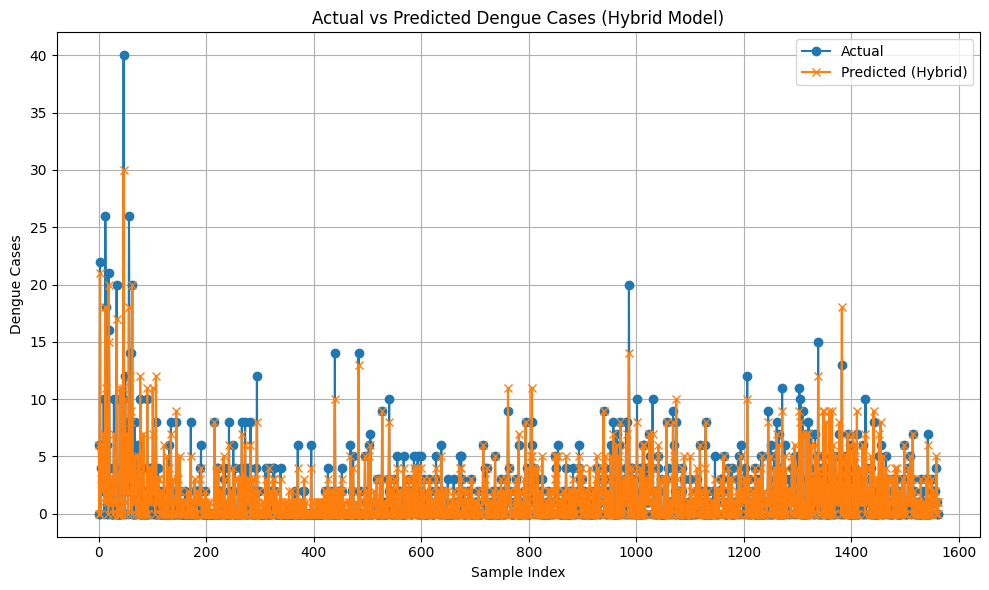

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(test_data['Dengue Cases'].values, label='Actual', marker='o')
plt.plot(test_data['Predicted Cases (Hybrid)'].values, label='Predicted (Hybrid)', marker='x')
plt.title('Actual vs Predicted Dengue Cases (Hybrid Model)')
plt.xlabel('Sample Index')
plt.ylabel('Dengue Cases')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
import os
import json

# Initialize dictionary to store ranges
thresholds_by_year = {}
average_per_range = {'Low': [], 'Medium': [], 'High': []}

# Group by year and calculate thresholds
for year, group in df.groupby('Year'):
    x = group['Dengue Cases'].mean()  # annual mean
    s = group['Dengue Cases'].std()   # annual std
    upper = x + 1.5 * s               # upper threshold for High

    # Storing thresholds for each year
    thresholds_by_year[year] = {
        'Low': f"Dengue Cases < {round(x):d}",
        'Medium': f"{round(x):d} < Dengue Cases < {round(upper):d}",
        'High': f"Dengue Cases > {round(upper):d}"
    }

    # Calculate average Dengue cases per range and store them
    low_avg = group[group['Dengue Cases'] < x]['Dengue Cases'].mean() if len(group[group['Dengue Cases'] < x]) > 0 else 0
    medium_avg = group[(group['Dengue Cases'] >= x) & (group['Dengue Cases'] <= upper)]['Dengue Cases'].mean() if len(group[(group['Dengue Cases'] >= x) & (group['Dengue Cases'] <= upper)]) > 0 else 0
    high_avg = group[group['Dengue Cases'] > upper]['Dengue Cases'].mean() if len(group[group['Dengue Cases'] > upper]) > 0 else 0

    # Store these averages
    average_per_range['Low'].append(low_avg)
    average_per_range['Medium'].append(medium_avg)
    average_per_range['High'].append(high_avg)

# Calculate the overall average for each range and round them to whole numbers
average_per_range_final = {level: round(sum(values) / len(values)) if len(values) > 0 else 0 
                           for level, values in average_per_range.items()}

# Define the thresholds for 2023 using the averages of all years
new_low = average_per_range_final['Low']
new_medium = average_per_range_final['Medium']
new_high = average_per_range_final['High']

# Calculate the mean for the new range definition
global_mean = round((new_low + new_medium + new_high) / 3)
upper_threshold = round(new_medium + 1.5 * (new_high - new_medium))  # Using the range between medium and high for the upper threshold

# Print the annual thresholds and the new thresholds for 2023
print("Annual Dengue Threat Level Ranges:")
for year, thresholds in sorted(thresholds_by_year.items()):
    print(f"\nYear {year}:")
    for level, condition in thresholds.items():
        print(f"  {level}: {condition}")

# Print the thresholds for 2023 based on the calculated averages
print(f"\nPredicted Dengue Threat Level Ranges for 2023:")
print(f"  Low: Dengue Cases < {new_low}")
print(f"  Medium: {new_low} < Dengue Cases < {new_high}")
print(f"  High: Dengue Cases > {new_high}")

Annual Dengue Threat Level Ranges:

Year 2011:
  Low: Dengue Cases < 0
  Medium: 0 < Dengue Cases < 1
  High: Dengue Cases > 1

Year 2012:
  Low: Dengue Cases < 1
  Medium: 1 < Dengue Cases < 3
  High: Dengue Cases > 3

Year 2013:
  Low: Dengue Cases < 1
  Medium: 1 < Dengue Cases < 3
  High: Dengue Cases > 3

Year 2014:
  Low: Dengue Cases < 1
  Medium: 1 < Dengue Cases < 4
  High: Dengue Cases > 4

Year 2015:
  Low: Dengue Cases < 2
  Medium: 2 < Dengue Cases < 6
  High: Dengue Cases > 6

Year 2016:
  Low: Dengue Cases < 3
  Medium: 3 < Dengue Cases < 10
  High: Dengue Cases > 10

Year 2017:
  Low: Dengue Cases < 1
  Medium: 1 < Dengue Cases < 3
  High: Dengue Cases > 3

Year 2018:
  Low: Dengue Cases < 3
  Medium: 3 < Dengue Cases < 10
  High: Dengue Cases > 10

Year 2019:
  Low: Dengue Cases < 8
  Medium: 8 < Dengue Cases < 28
  High: Dengue Cases > 28

Year 2020:
  Low: Dengue Cases < 2
  Medium: 2 < Dengue Cases < 8
  High: Dengue Cases > 8

Year 2021:
  Low: Dengue Cases < 1
  M